In [4]:
# Importing the modules
!pip install keras
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
#from keras.layers.advanced_activations import LeakyReLU

The **Generator networks** takes random noise as input and tries to recreate the images from the training set and the

The **discriminator** is binary classifier tries to distinguish the images generated by the generator network from the actual train images.

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam

def build_generator():
    generator = Sequential([
        Dense(256, input_dim=100),
        LeakyReLU(0.2),
        BatchNormalization(),

        Dense(512),
        LeakyReLU(0.2),
        BatchNormalization(),

        Dense(1024),
        LeakyReLU(0.2),
        BatchNormalization(),

        Dense(784, activation='tanh')
    ])

    generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return generator


In [6]:

def build_discriminator():
    discriminator = Sequential([
        Dense(1024, input_dim=784),
        LeakyReLU(0.2),
        Dropout(0.2),

        Dense(512),
        LeakyReLU(0.2),
        Dropout(0.3),

        Dense(256),
        LeakyReLU(0.2),
        Dropout(0.3),

        Dense(128),
        LeakyReLU(0.2),

        Dense(1, activation='sigmoid')
    ])

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return discriminator


**Sequential:** Permite crear una red neuronal capa por capa.

**Dense:** Capa densa (totalmente conectada).
LeakyReLU(0.2):** Función de activación con un pequeño gradiente para valores negativos.

**Dropout(x):** Reduce el sobreajuste al desactivar aleatoriamente neuronas en cada iteración.

**Adam:** Optimizador para mejorar el entrenamiento.


In [7]:
from keras.models import Model
from keras.layers import Input

def gan_net(generator, discriminator):
    discriminator.trainable = False  # Bloqueamos el entrenamiento del discriminador

    inp = Input(shape=(100,))  # Entrada de ruido para el generador
    X = generator(inp)  # Generador crea una imagen falsa
    out = discriminator(X)  # Discriminador evalúa la imagen generada

    gan = Model(inputs=inp, outputs=out)  # Creamos la GAN combinando ambos modelos
    gan.compile(loss='binary_crossentropy', optimizer='adam')  # Compilamos el modelo

    return gan


In [8]:
#method to plot the images

def plot_images(epoch, generator,dim=(10,10),figsize=(10,10)):
    #generate a normally distributed noise of shape (100x100)
    noise=np.random.normal(loc=0,scale=1,size=[100,100])
    #generate an image for the input noise
    noise=np.random.normal(loc=0,scale=1,size=[100,100])

    #generate an image for the input noise

    generated_images=generator.predict(noise)

    #reshape the generated image
    generated_images=generated_images.reshape(100,28,28)

    #plot the image
    plt.figure(figsize=figsize)

    #plot for each pixel

    for i in range(generated_images.shape[0]):

        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow(generated_images[i],cmap='gray',interpolation='nearest')
        plt.axis('off')
        plt.tight_layout()

In [12]:
import numpy as np
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Dropout
from keras.optimizers import Adam

def train(X_train, epochs=5, batch_size=128):
    generator = build_generator()
    discriminator = build_discriminator()
    gan = gan_net(generator, discriminator)

    for epoch in range(1, epochs + 1):
        print(f"###### @ Epoch {epoch}")

        for _ in tqdm(range(batch_size)):
            noise = np.random.normal(0, 1, (batch_size, 100))  # Ruido aleatorio
            generated_images = generator.predict(noise)  # Generar imágenes falsas

            # Seleccionar imágenes reales al azar
            real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

            # Combinar imágenes reales y generadas
            X = np.concatenate([real_images, generated_images])

            # Etiquetas: 1 para reales, 0 para falsas
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 1

            # Entrenar discriminador
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Entrenar generador (intentando engañar al discriminador)
            noise = np.random.normal(0, 1, (batch_size, 100))
            y_gen = np.ones(batch_size)  # Etiquetas falsas como reales

            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        # Guardar imágenes cada 10 épocas
        if epoch == 1 or epoch % 10 == 0:
            plot_images(epoch, generator, dim=(10, 10), figsize=(15, 15))


In [13]:
#Unpacking the training data from mnist dataset
(X_train,_),(_,_)=mnist.load_data()

#converting to float type and normalizing the data

X_train=(X_train.astype(np.float32)-127.5)/127.5

#convert shape of X_train from (60000,28,28) to (60000, 784) -784 coloumns per row

X_train=X_train.reshape(60000,784)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


###### @ Epoch 1


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


  1%|          | 1/128 [00:05<11:16,  5.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  2%|▏         | 2/128 [00:05<04:52,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  2%|▏         | 3/128 [00:05<02:51,  1.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  3%|▎         | 4/128 [00:06<01:54,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  4%|▍         | 5/128 [00:06<01:21,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  5%|▍         | 6/128 [00:06<01:03,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 7/128 [00:06<00:57,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▋         | 8/128 [00:07<00:51,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 9/128 [00:07<00:50,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  8%|▊         | 10/128 [00:08<00:49,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|▊         | 11/128 [00:08<00:45,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|▉         | 12/128 [00:08<00:45,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|█         | 13/128 [00:09<00:47,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█         | 14/128 [00:09<00:47,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▏        | 15/128 [00:09<00:44,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 12%|█▎        | 16/128 [00:10<00:37,  2.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 13%|█▎        | 17/128 [00:10<00:33,  3.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 14%|█▍        | 18/128 [00:10<00:31,  3.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 15%|█▍        | 19/128 [00:10<00:29,  3.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 16%|█▌        | 20/128 [00:11<00:27,  3.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 16%|█▋        | 21/128 [00:11<00:25,  4.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 17%|█▋        | 22/128 [00:11<00:25,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 18%|█▊        | 23/128 [00:11<00:24,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 19%|█▉        | 24/128 [00:11<00:24,  4.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 20%|█▉        | 25/128 [00:12<00:23,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 20%|██        | 26/128 [00:12<00:22,  4.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 21%|██        | 27/128 [00:12<00:23,  4.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 22%|██▏       | 28/128 [00:12<00:23,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 23%|██▎       | 29/128 [00:13<00:22,  4.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 23%|██▎       | 30/128 [00:13<00:22,  4.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 24%|██▍       | 31/128 [00:13<00:22,  4.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 25%|██▌       | 32/128 [00:13<00:21,  4.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 26%|██▌       | 33/128 [00:13<00:21,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 27%|██▋       | 34/128 [00:14<00:21,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 27%|██▋       | 35/128 [00:14<00:20,  4.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 28%|██▊       | 36/128 [00:14<00:20,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 29%|██▉       | 37/128 [00:14<00:20,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 30%|██▉       | 38/128 [00:15<00:19,  4.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 30%|███       | 39/128 [00:15<00:19,  4.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 31%|███▏      | 40/128 [00:15<00:19,  4.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 32%|███▏      | 41/128 [00:15<00:19,  4.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 33%|███▎      | 42/128 [00:16<00:19,  4.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 34%|███▎      | 43/128 [00:16<00:19,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 34%|███▍      | 44/128 [00:16<00:18,  4.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 35%|███▌      | 45/128 [00:16<00:18,  4.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 36%|███▌      | 46/128 [00:16<00:18,  4.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 37%|███▋      | 47/128 [00:17<00:18,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 38%|███▊      | 48/128 [00:17<00:17,  4.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 38%|███▊      | 49/128 [00:17<00:18,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 39%|███▉      | 50/128 [00:17<00:17,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 40%|███▉      | 51/128 [00:18<00:17,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 41%|████      | 52/128 [00:18<00:17,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 41%|████▏     | 53/128 [00:18<00:17,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 42%|████▏     | 54/128 [00:18<00:17,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 43%|████▎     | 55/128 [00:18<00:17,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 44%|████▍     | 56/128 [00:19<00:16,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 45%|████▍     | 57/128 [00:19<00:15,  4.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 45%|████▌     | 58/128 [00:19<00:15,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 46%|████▌     | 59/128 [00:19<00:16,  4.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 60/128 [00:20<00:20,  3.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 48%|████▊     | 61/128 [00:20<00:20,  3.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 48%|████▊     | 62/128 [00:21<00:20,  3.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████▉     | 63/128 [00:21<00:21,  2.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 64/128 [00:21<00:21,  2.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 51%|█████     | 65/128 [00:22<00:22,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|█████▏    | 66/128 [00:22<00:21,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 67/128 [00:22<00:21,  2.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 68/128 [00:23<00:22,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 54%|█████▍    | 69/128 [00:23<00:20,  2.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 55%|█████▍    | 70/128 [00:23<00:17,  3.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 55%|█████▌    | 71/128 [00:24<00:16,  3.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 56%|█████▋    | 72/128 [00:24<00:14,  3.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 57%|█████▋    | 73/128 [00:24<00:13,  3.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 58%|█████▊    | 74/128 [00:24<00:13,  4.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 59%|█████▊    | 75/128 [00:24<00:12,  4.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 59%|█████▉    | 76/128 [00:25<00:12,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 60%|██████    | 77/128 [00:25<00:11,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 61%|██████    | 78/128 [00:25<00:11,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 62%|██████▏   | 79/128 [00:25<00:11,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 62%|██████▎   | 80/128 [00:26<00:10,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 63%|██████▎   | 81/128 [00:26<00:10,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 64%|██████▍   | 82/128 [00:26<00:10,  4.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 65%|██████▍   | 83/128 [00:26<00:10,  4.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 66%|██████▌   | 84/128 [00:26<00:09,  4.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 66%|██████▋   | 85/128 [00:27<00:09,  4.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 67%|██████▋   | 86/128 [00:27<00:09,  4.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 68%|██████▊   | 87/128 [00:27<00:09,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 69%|██████▉   | 88/128 [00:27<00:08,  4.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 70%|██████▉   | 89/128 [00:28<00:08,  4.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 70%|███████   | 90/128 [00:28<00:08,  4.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 71%|███████   | 91/128 [00:28<00:08,  4.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 72%|███████▏  | 92/128 [00:28<00:08,  4.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 73%|███████▎  | 93/128 [00:28<00:07,  4.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 73%|███████▎  | 94/128 [00:29<00:07,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 74%|███████▍  | 95/128 [00:29<00:07,  4.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 75%|███████▌  | 96/128 [00:29<00:07,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 76%|███████▌  | 97/128 [00:29<00:07,  4.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 77%|███████▋  | 98/128 [00:30<00:06,  4.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 77%|███████▋  | 99/128 [00:30<00:06,  4.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 78%|███████▊  | 100/128 [00:30<00:06,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 79%|███████▉  | 101/128 [00:30<00:06,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 80%|███████▉  | 102/128 [00:30<00:05,  4.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 80%|████████  | 103/128 [00:31<00:05,  4.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 81%|████████▏ | 104/128 [00:31<00:05,  4.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 82%|████████▏ | 105/128 [00:31<00:05,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 83%|████████▎ | 106/128 [00:31<00:05,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 84%|████████▎ | 107/128 [00:32<00:04,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 84%|████████▍ | 108/128 [00:32<00:04,  4.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 85%|████████▌ | 109/128 [00:32<00:04,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 86%|████████▌ | 110/128 [00:32<00:04,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 87%|████████▋ | 111/128 [00:33<00:03,  4.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 88%|████████▊ | 112/128 [00:33<00:03,  4.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 88%|████████▊ | 113/128 [00:33<00:03,  4.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 89%|████████▉ | 114/128 [00:33<00:04,  3.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 90%|████████▉ | 115/128 [00:34<00:04,  3.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 116/128 [00:34<00:04,  2.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 91%|█████████▏| 117/128 [00:35<00:03,  2.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 92%|█████████▏| 118/128 [00:35<00:03,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 119/128 [00:35<00:03,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 120/128 [00:36<00:02,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▍| 121/128 [00:36<00:02,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 122/128 [00:36<00:02,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 96%|█████████▌| 123/128 [00:37<00:01,  3.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 97%|█████████▋| 124/128 [00:37<00:01,  3.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 98%|█████████▊| 125/128 [00:37<00:00,  3.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 98%|█████████▊| 126/128 [00:37<00:00,  3.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 99%|█████████▉| 127/128 [00:38<00:00,  4.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


100%|██████████| 128/128 [00:38<00:00,  3.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


###### @ Epoch 2


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  1%|          | 1/128 [00:00<00:30,  4.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  2%|▏         | 2/128 [00:00<00:29,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  2%|▏         | 3/128 [00:00<00:27,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  3%|▎         | 4/128 [00:00<00:27,  4.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  4%|▍         | 5/128 [00:01<00:27,  4.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  5%|▍         | 6/128 [00:01<00:29,  4.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  5%|▌         | 7/128 [00:01<00:32,  3.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▋         | 8/128 [00:02<00:37,  3.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 9/128 [00:02<00:41,  2.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  8%|▊         | 10/128 [00:02<00:43,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|▊         | 11/128 [00:03<00:42,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 12/128 [00:03<00:43,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 10%|█         | 13/128 [00:04<00:45,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 14/128 [00:04<00:43,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 12%|█▏        | 15/128 [00:04<00:36,  3.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 12%|█▎        | 16/128 [00:04<00:32,  3.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 13%|█▎        | 17/128 [00:05<00:30,  3.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 14%|█▍        | 18/128 [00:05<00:28,  3.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 15%|█▍        | 19/128 [00:05<00:27,  4.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 16%|█▌        | 20/128 [00:05<00:26,  4.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 16%|█▋        | 21/128 [00:06<00:25,  4.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 17%|█▋        | 22/128 [00:06<00:24,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 18%|█▊        | 23/128 [00:06<00:24,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 19%|█▉        | 24/128 [00:06<00:23,  4.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 20%|█▉        | 25/128 [00:06<00:23,  4.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 20%|██        | 26/128 [00:07<00:23,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 21%|██        | 27/128 [00:07<00:23,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 22%|██▏       | 28/128 [00:07<00:23,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 23%|██▎       | 29/128 [00:07<00:22,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 23%|██▎       | 30/128 [00:08<00:22,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 24%|██▍       | 31/128 [00:08<00:22,  4.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 25%|██▌       | 32/128 [00:08<00:22,  4.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 26%|██▌       | 33/128 [00:08<00:21,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 27%|██▋       | 34/128 [00:09<00:21,  4.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 27%|██▋       | 35/128 [00:09<00:21,  4.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 28%|██▊       | 36/128 [00:09<00:21,  4.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 29%|██▉       | 37/128 [00:09<00:20,  4.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 30%|██▉       | 38/128 [00:09<00:20,  4.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 30%|███       | 39/128 [00:10<00:20,  4.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 31%|███▏      | 40/128 [00:10<00:19,  4.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 32%|███▏      | 41/128 [00:10<00:20,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 33%|███▎      | 42/128 [00:10<00:19,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 34%|███▎      | 43/128 [00:11<00:19,  4.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 34%|███▍      | 44/128 [00:11<00:19,  4.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 35%|███▌      | 45/128 [00:11<00:18,  4.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▌      | 46/128 [00:11<00:18,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 37%|███▋      | 47/128 [00:11<00:18,  4.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 38%|███▊      | 48/128 [00:12<00:17,  4.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 38%|███▊      | 49/128 [00:12<00:17,  4.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 39%|███▉      | 50/128 [00:12<00:17,  4.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 40%|███▉      | 51/128 [00:12<00:17,  4.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 41%|████      | 52/128 [00:13<00:17,  4.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 41%|████▏     | 53/128 [00:13<00:16,  4.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 42%|████▏     | 54/128 [00:13<00:16,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 43%|████▎     | 55/128 [00:13<00:16,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 44%|████▍     | 56/128 [00:14<00:16,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 45%|████▍     | 57/128 [00:14<00:16,  4.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 45%|████▌     | 58/128 [00:14<00:17,  4.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 46%|████▌     | 59/128 [00:14<00:18,  3.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 60/128 [00:15<00:19,  3.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 61/128 [00:15<00:20,  3.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 62/128 [00:15<00:22,  2.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 63/128 [00:16<00:22,  2.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 64/128 [00:16<00:21,  2.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 51%|█████     | 65/128 [00:17<00:22,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 66/128 [00:17<00:23,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 67/128 [00:17<00:21,  2.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 68/128 [00:18<00:20,  2.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 54%|█████▍    | 69/128 [00:18<00:17,  3.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 55%|█████▍    | 70/128 [00:18<00:15,  3.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 55%|█████▌    | 71/128 [00:18<00:14,  3.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 56%|█████▋    | 72/128 [00:18<00:14,  3.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 57%|█████▋    | 73/128 [00:19<00:13,  4.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 58%|█████▊    | 74/128 [00:19<00:12,  4.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 59%|█████▊    | 75/128 [00:19<00:12,  4.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 59%|█████▉    | 76/128 [00:19<00:12,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 60%|██████    | 77/128 [00:20<00:11,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 61%|██████    | 78/128 [00:20<00:11,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 62%|██████▏   | 79/128 [00:20<00:11,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 62%|██████▎   | 80/128 [00:20<00:11,  4.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 63%|██████▎   | 81/128 [00:21<00:10,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 64%|██████▍   | 82/128 [00:21<00:10,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 65%|██████▍   | 83/128 [00:21<00:10,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 66%|██████▌   | 84/128 [00:21<00:09,  4.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 66%|██████▋   | 85/128 [00:21<00:09,  4.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 67%|██████▋   | 86/128 [00:22<00:09,  4.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 68%|██████▊   | 87/128 [00:22<00:09,  4.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 69%|██████▉   | 88/128 [00:22<00:09,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 70%|██████▉   | 89/128 [00:22<00:08,  4.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 70%|███████   | 90/128 [00:23<00:08,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 71%|███████   | 91/128 [00:23<00:08,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 72%|███████▏  | 92/128 [00:23<00:08,  4.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 73%|███████▎  | 93/128 [00:23<00:07,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 73%|███████▎  | 94/128 [00:23<00:07,  4.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 95/128 [00:24<00:07,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 75%|███████▌  | 96/128 [00:24<00:07,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 76%|███████▌  | 97/128 [00:24<00:07,  4.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 77%|███████▋  | 98/128 [00:24<00:06,  4.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 77%|███████▋  | 99/128 [00:25<00:06,  4.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 78%|███████▊  | 100/128 [00:25<00:06,  4.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 79%|███████▉  | 101/128 [00:25<00:06,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 80%|███████▉  | 102/128 [00:25<00:05,  4.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 80%|████████  | 103/128 [00:26<00:05,  4.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 81%|████████▏ | 104/128 [00:26<00:05,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 82%|████████▏ | 105/128 [00:26<00:05,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 83%|████████▎ | 106/128 [00:26<00:04,  4.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 84%|████████▎ | 107/128 [00:26<00:04,  4.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 84%|████████▍ | 108/128 [00:27<00:04,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 85%|████████▌ | 109/128 [00:27<00:04,  4.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 86%|████████▌ | 110/128 [00:27<00:04,  4.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 111/128 [00:28<00:04,  3.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|████████▊ | 112/128 [00:28<00:05,  3.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 113/128 [00:28<00:04,  3.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|████████▉ | 114/128 [00:29<00:04,  3.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████▉ | 115/128 [00:29<00:04,  3.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 91%|█████████ | 116/128 [00:29<00:03,  3.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████▏| 117/128 [00:30<00:03,  2.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 118/128 [00:30<00:03,  2.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 119/128 [00:30<00:03,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 120/128 [00:31<00:02,  2.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 95%|█████████▍| 121/128 [00:31<00:02,  3.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 95%|█████████▌| 122/128 [00:31<00:01,  3.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 96%|█████████▌| 123/128 [00:31<00:01,  3.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 97%|█████████▋| 124/128 [00:32<00:01,  3.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 98%|█████████▊| 125/128 [00:32<00:00,  4.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 98%|█████████▊| 126/128 [00:32<00:00,  4.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 99%|█████████▉| 127/128 [00:32<00:00,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


100%|██████████| 128/128 [00:33<00:00,  3.88it/s]


###### @ Epoch 3


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  1%|          | 1/128 [00:00<00:28,  4.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  2%|▏         | 2/128 [00:00<00:29,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  2%|▏         | 3/128 [00:00<00:28,  4.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  3%|▎         | 4/128 [00:00<00:27,  4.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  4%|▍         | 5/128 [00:01<00:27,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  5%|▍         | 6/128 [00:01<00:27,  4.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  5%|▌         | 7/128 [00:01<00:28,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  6%|▋         | 8/128 [00:01<00:27,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  7%|▋         | 9/128 [00:02<00:30,  3.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  8%|▊         | 10/128 [00:02<00:29,  4.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▊         | 11/128 [00:02<00:28,  4.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  9%|▉         | 12/128 [00:02<00:27,  4.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 10%|█         | 13/128 [00:03<00:26,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 11%|█         | 14/128 [00:03<00:26,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 12%|█▏        | 15/128 [00:03<00:26,  4.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 12%|█▎        | 16/128 [00:03<00:25,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 13%|█▎        | 17/128 [00:03<00:25,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 14%|█▍        | 18/128 [00:04<00:26,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 15%|█▍        | 19/128 [00:04<00:25,  4.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 16%|█▌        | 20/128 [00:04<00:25,  4.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 16%|█▋        | 21/128 [00:04<00:25,  4.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 17%|█▋        | 22/128 [00:05<00:24,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 18%|█▊        | 23/128 [00:05<00:24,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 19%|█▉        | 24/128 [00:05<00:24,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 20%|█▉        | 25/128 [00:05<00:23,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 20%|██        | 26/128 [00:06<00:23,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 21%|██        | 27/128 [00:06<00:23,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 22%|██▏       | 28/128 [00:06<00:23,  4.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 23%|██▎       | 29/128 [00:06<00:22,  4.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 23%|██▎       | 30/128 [00:07<00:22,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 24%|██▍       | 31/128 [00:07<00:21,  4.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 25%|██▌       | 32/128 [00:07<00:21,  4.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 26%|██▌       | 33/128 [00:07<00:21,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 27%|██▋       | 34/128 [00:07<00:21,  4.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 27%|██▋       | 35/128 [00:08<00:22,  4.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 36/128 [00:08<00:26,  3.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██▉       | 37/128 [00:08<00:29,  3.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 38/128 [00:09<00:31,  2.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███       | 39/128 [00:09<00:32,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███▏      | 40/128 [00:10<00:33,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 41/128 [00:10<00:34,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 42/128 [00:11<00:34,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|███▎      | 43/128 [00:11<00:32,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 34%|███▍      | 44/128 [00:11<00:28,  2.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 35%|███▌      | 45/128 [00:11<00:25,  3.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 36%|███▌      | 46/128 [00:12<00:23,  3.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 37%|███▋      | 47/128 [00:12<00:21,  3.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 38%|███▊      | 48/128 [00:12<00:20,  3.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 38%|███▊      | 49/128 [00:12<00:19,  4.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 39%|███▉      | 50/128 [00:12<00:18,  4.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 40%|███▉      | 51/128 [00:13<00:18,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 41%|████      | 52/128 [00:13<00:17,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 41%|████▏     | 53/128 [00:13<00:17,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 42%|████▏     | 54/128 [00:13<00:17,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 43%|████▎     | 55/128 [00:14<00:17,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 44%|████▍     | 56/128 [00:14<00:16,  4.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 45%|████▍     | 57/128 [00:14<00:16,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 45%|████▌     | 58/128 [00:14<00:15,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 46%|████▌     | 59/128 [00:15<00:15,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 47%|████▋     | 60/128 [00:15<00:15,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 48%|████▊     | 61/128 [00:15<00:15,  4.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 48%|████▊     | 62/128 [00:15<00:14,  4.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 49%|████▉     | 63/128 [00:15<00:14,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 50%|█████     | 64/128 [00:16<00:14,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 51%|█████     | 65/128 [00:16<00:14,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 52%|█████▏    | 66/128 [00:16<00:14,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 52%|█████▏    | 67/128 [00:16<00:14,  4.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 53%|█████▎    | 68/128 [00:17<00:13,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 54%|█████▍    | 69/128 [00:17<00:13,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 55%|█████▍    | 70/128 [00:17<00:13,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 55%|█████▌    | 71/128 [00:17<00:12,  4.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 56%|█████▋    | 72/128 [00:18<00:12,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 57%|█████▋    | 73/128 [00:18<00:12,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 58%|█████▊    | 74/128 [00:18<00:12,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 59%|█████▊    | 75/128 [00:18<00:12,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 59%|█████▉    | 76/128 [00:18<00:12,  4.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|██████    | 77/128 [00:19<00:12,  3.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 61%|██████    | 78/128 [00:19<00:12,  4.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 62%|██████▏   | 79/128 [00:19<00:11,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 62%|██████▎   | 80/128 [00:19<00:11,  4.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 63%|██████▎   | 81/128 [00:20<00:11,  4.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 64%|██████▍   | 82/128 [00:20<00:10,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 65%|██████▍   | 83/128 [00:20<00:10,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 66%|██████▌   | 84/128 [00:20<00:10,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 66%|██████▋   | 85/128 [00:21<00:10,  4.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 86/128 [00:21<00:11,  3.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 68%|██████▊   | 87/128 [00:21<00:13,  3.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 69%|██████▉   | 88/128 [00:22<00:13,  3.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 70%|██████▉   | 89/128 [00:22<00:12,  3.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|███████   | 90/128 [00:22<00:12,  3.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 91/128 [00:23<00:13,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 92/128 [00:23<00:13,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 93/128 [00:24<00:13,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 94/128 [00:24<00:13,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 74%|███████▍  | 95/128 [00:24<00:11,  2.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 75%|███████▌  | 96/128 [00:25<00:10,  3.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 76%|███████▌  | 97/128 [00:25<00:08,  3.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 77%|███████▋  | 98/128 [00:25<00:08,  3.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 77%|███████▋  | 99/128 [00:25<00:07,  3.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 78%|███████▊  | 100/128 [00:26<00:07,  3.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 79%|███████▉  | 101/128 [00:26<00:06,  3.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 80%|███████▉  | 102/128 [00:26<00:06,  4.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 80%|████████  | 103/128 [00:26<00:06,  4.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 81%|████████▏ | 104/128 [00:26<00:05,  4.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 82%|████████▏ | 105/128 [00:27<00:05,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 83%|████████▎ | 106/128 [00:27<00:05,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 84%|████████▎ | 107/128 [00:27<00:04,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 84%|████████▍ | 108/128 [00:27<00:04,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 85%|████████▌ | 109/128 [00:28<00:04,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 86%|████████▌ | 110/128 [00:28<00:04,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 87%|████████▋ | 111/128 [00:28<00:03,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 88%|████████▊ | 112/128 [00:28<00:03,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 88%|████████▊ | 113/128 [00:29<00:03,  4.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 89%|████████▉ | 114/128 [00:29<00:03,  4.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 90%|████████▉ | 115/128 [00:29<00:02,  4.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 91%|█████████ | 116/128 [00:29<00:02,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 91%|█████████▏| 117/128 [00:29<00:02,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 92%|█████████▏| 118/128 [00:30<00:02,  4.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 93%|█████████▎| 119/128 [00:30<00:02,  4.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 94%|█████████▍| 120/128 [00:30<00:01,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 95%|█████████▍| 121/128 [00:30<00:01,  4.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 95%|█████████▌| 122/128 [00:31<00:01,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 96%|█████████▌| 123/128 [00:31<00:01,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 97%|█████████▋| 124/128 [00:31<00:00,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 98%|█████████▊| 125/128 [00:31<00:00,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 98%|█████████▊| 126/128 [00:32<00:00,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 99%|█████████▉| 127/128 [00:32<00:00,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


100%|██████████| 128/128 [00:32<00:00,  3.93it/s]


###### @ Epoch 4


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|          | 1/128 [00:00<00:53,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  2%|▏         | 2/128 [00:00<00:51,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 3/128 [00:01<00:46,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 4/128 [00:01<00:46,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 5/128 [00:01<00:46,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 6/128 [00:02<00:48,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 7/128 [00:02<00:52,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  6%|▋         | 8/128 [00:03<00:50,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 9/128 [00:03<00:51,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  8%|▊         | 10/128 [00:04<00:51,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  9%|▊         | 11/128 [00:04<00:51,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  9%|▉         | 12/128 [00:05<00:49,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|█         | 13/128 [00:05<00:48,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 14/128 [00:05<00:46,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 15/128 [00:06<00:46,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▎        | 16/128 [00:06<00:46,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 13%|█▎        | 17/128 [00:06<00:40,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 14%|█▍        | 18/128 [00:07<00:35,  3.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 15%|█▍        | 19/128 [00:07<00:32,  3.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 16%|█▌        | 20/128 [00:07<00:30,  3.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 16%|█▋        | 21/128 [00:07<00:28,  3.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 17%|█▋        | 22/128 [00:08<00:27,  3.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 18%|█▊        | 23/128 [00:08<00:25,  4.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▉        | 24/128 [00:08<00:28,  3.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 20%|█▉        | 25/128 [00:08<00:26,  3.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 20%|██        | 26/128 [00:09<00:25,  3.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 21%|██        | 27/128 [00:09<00:24,  4.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 22%|██▏       | 28/128 [00:09<00:24,  4.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 23%|██▎       | 29/128 [00:09<00:23,  4.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 23%|██▎       | 30/128 [00:10<00:23,  4.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 24%|██▍       | 31/128 [00:10<00:23,  4.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 25%|██▌       | 32/128 [00:10<00:22,  4.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 26%|██▌       | 33/128 [00:10<00:22,  4.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 27%|██▋       | 34/128 [00:10<00:22,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 27%|██▋       | 35/128 [00:11<00:21,  4.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 28%|██▊       | 36/128 [00:11<00:21,  4.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 29%|██▉       | 37/128 [00:11<00:21,  4.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 30%|██▉       | 38/128 [00:11<00:21,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 30%|███       | 39/128 [00:12<00:20,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 31%|███▏      | 40/128 [00:12<00:20,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 32%|███▏      | 41/128 [00:12<00:20,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 42/128 [00:12<00:20,  4.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 34%|███▎      | 43/128 [00:13<00:19,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 34%|███▍      | 44/128 [00:13<00:19,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 35%|███▌      | 45/128 [00:13<00:19,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 36%|███▌      | 46/128 [00:13<00:19,  4.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 37%|███▋      | 47/128 [00:14<00:18,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 38%|███▊      | 48/128 [00:14<00:18,  4.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 38%|███▊      | 49/128 [00:14<00:17,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 39%|███▉      | 50/128 [00:14<00:17,  4.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 40%|███▉      | 51/128 [00:14<00:19,  3.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 41%|████      | 52/128 [00:15<00:18,  4.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 41%|████▏     | 53/128 [00:15<00:18,  4.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 42%|████▏     | 54/128 [00:15<00:17,  4.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 55/128 [00:16<00:19,  3.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 44%|████▍     | 56/128 [00:16<00:18,  3.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 45%|████▍     | 57/128 [00:16<00:17,  4.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 45%|████▌     | 58/128 [00:16<00:16,  4.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 59/128 [00:17<00:19,  3.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 60/128 [00:17<00:21,  3.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 61/128 [00:17<00:22,  2.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 62/128 [00:18<00:24,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████▉     | 63/128 [00:18<00:24,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 64/128 [00:19<00:24,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 65/128 [00:19<00:24,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 66/128 [00:19<00:23,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 67/128 [00:20<00:23,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 53%|█████▎    | 68/128 [00:20<00:20,  2.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 54%|█████▍    | 69/128 [00:20<00:18,  3.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 55%|█████▍    | 70/128 [00:20<00:16,  3.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 55%|█████▌    | 71/128 [00:21<00:15,  3.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 56%|█████▋    | 72/128 [00:21<00:14,  3.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 57%|█████▋    | 73/128 [00:21<00:13,  3.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 58%|█████▊    | 74/128 [00:21<00:13,  4.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 59%|█████▊    | 75/128 [00:22<00:12,  4.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 59%|█████▉    | 76/128 [00:22<00:12,  4.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 60%|██████    | 77/128 [00:22<00:12,  4.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 61%|██████    | 78/128 [00:22<00:11,  4.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 62%|██████▏   | 79/128 [00:23<00:11,  4.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 62%|██████▎   | 80/128 [00:23<00:11,  4.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 63%|██████▎   | 81/128 [00:23<00:11,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 64%|██████▍   | 82/128 [00:23<00:10,  4.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 65%|██████▍   | 83/128 [00:24<00:10,  4.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 66%|██████▌   | 84/128 [00:24<00:10,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 66%|██████▋   | 85/128 [00:24<00:10,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 67%|██████▋   | 86/128 [00:24<00:09,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 68%|██████▊   | 87/128 [00:24<00:09,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 69%|██████▉   | 88/128 [00:25<00:09,  4.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 70%|██████▉   | 89/128 [00:25<00:09,  4.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 70%|███████   | 90/128 [00:25<00:09,  4.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 71%|███████   | 91/128 [00:25<00:08,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 72%|███████▏  | 92/128 [00:26<00:08,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 73%|███████▎  | 93/128 [00:26<00:08,  4.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 73%|███████▎  | 94/128 [00:26<00:08,  4.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 74%|███████▍  | 95/128 [00:26<00:07,  4.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 75%|███████▌  | 96/128 [00:27<00:07,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 97/128 [00:27<00:07,  4.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 77%|███████▋  | 98/128 [00:27<00:07,  4.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 77%|███████▋  | 99/128 [00:27<00:06,  4.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 78%|███████▊  | 100/128 [00:28<00:06,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 79%|███████▉  | 101/128 [00:28<00:06,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 80%|███████▉  | 102/128 [00:28<00:06,  4.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 80%|████████  | 103/128 [00:28<00:05,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 81%|████████▏ | 104/128 [00:28<00:05,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 82%|████████▏ | 105/128 [00:29<00:05,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 83%|████████▎ | 106/128 [00:29<00:05,  4.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 84%|████████▎ | 107/128 [00:29<00:05,  4.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 84%|████████▍ | 108/128 [00:29<00:04,  4.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 85%|████████▌ | 109/128 [00:30<00:04,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 86%|████████▌ | 110/128 [00:30<00:04,  3.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 87%|████████▋ | 111/128 [00:30<00:04,  3.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 112/128 [00:31<00:05,  3.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████▊ | 113/128 [00:31<00:05,  2.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 114/128 [00:32<00:05,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|████████▉ | 115/128 [00:32<00:04,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 116/128 [00:32<00:04,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████▏| 117/128 [00:33<00:04,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 118/128 [00:33<00:03,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 119/128 [00:34<00:03,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 94%|█████████▍| 120/128 [00:34<00:02,  2.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 95%|█████████▍| 121/128 [00:34<00:02,  3.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 95%|█████████▌| 122/128 [00:34<00:01,  3.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 96%|█████████▌| 123/128 [00:34<00:01,  3.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 97%|█████████▋| 124/128 [00:35<00:01,  3.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 98%|█████████▊| 125/128 [00:35<00:00,  3.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 98%|█████████▊| 126/128 [00:35<00:00,  3.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 99%|█████████▉| 127/128 [00:35<00:00,  4.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


100%|██████████| 128/128 [00:36<00:00,  3.54it/s]


###### @ Epoch 5


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  1%|          | 1/128 [00:00<00:31,  4.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  2%|▏         | 2/128 [00:00<00:29,  4.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  2%|▏         | 3/128 [00:00<00:29,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  3%|▎         | 4/128 [00:00<00:28,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  4%|▍         | 5/128 [00:01<00:29,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  5%|▍         | 6/128 [00:01<00:28,  4.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  5%|▌         | 7/128 [00:01<00:28,  4.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  6%|▋         | 8/128 [00:01<00:28,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  7%|▋         | 9/128 [00:02<00:27,  4.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  8%|▊         | 10/128 [00:02<00:30,  3.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  9%|▊         | 11/128 [00:02<00:29,  3.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  9%|▉         | 12/128 [00:02<00:28,  4.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 10%|█         | 13/128 [00:03<00:28,  4.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 11%|█         | 14/128 [00:03<00:27,  4.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 12%|█▏        | 15/128 [00:03<00:27,  4.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 12%|█▎        | 16/128 [00:03<00:26,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 13%|█▎        | 17/128 [00:04<00:25,  4.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 14%|█▍        | 18/128 [00:04<00:25,  4.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 15%|█▍        | 19/128 [00:04<00:25,  4.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 20/128 [00:04<00:27,  3.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 16%|█▋        | 21/128 [00:05<00:26,  3.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 17%|█▋        | 22/128 [00:05<00:26,  3.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 18%|█▊        | 23/128 [00:05<00:25,  4.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 19%|█▉        | 24/128 [00:05<00:25,  4.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 20%|█▉        | 25/128 [00:06<00:25,  4.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 20%|██        | 26/128 [00:06<00:24,  4.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 21%|██        | 27/128 [00:06<00:24,  4.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 22%|██▏       | 28/128 [00:06<00:24,  4.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 23%|██▎       | 29/128 [00:07<00:23,  4.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 23%|██▎       | 30/128 [00:07<00:23,  4.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 24%|██▍       | 31/128 [00:07<00:22,  4.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 25%|██▌       | 32/128 [00:07<00:22,  4.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 26%|██▌       | 33/128 [00:08<00:24,  3.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 34/128 [00:08<00:27,  3.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 35/128 [00:08<00:30,  3.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 28%|██▊       | 36/128 [00:09<00:30,  3.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 37/128 [00:09<00:31,  2.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██▉       | 38/128 [00:09<00:30,  2.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 39/128 [00:10<00:30,  2.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███▏      | 40/128 [00:10<00:30,  2.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 41/128 [00:11<00:32,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 42/128 [00:11<00:33,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▎      | 43/128 [00:11<00:31,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 34%|███▍      | 44/128 [00:12<00:28,  2.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 35%|███▌      | 45/128 [00:12<00:25,  3.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 36%|███▌      | 46/128 [00:12<00:23,  3.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 37%|███▋      | 47/128 [00:12<00:21,  3.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 38%|███▊      | 48/128 [00:12<00:20,  3.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 38%|███▊      | 49/128 [00:13<00:21,  3.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 39%|███▉      | 50/128 [00:13<00:20,  3.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 40%|███▉      | 51/128 [00:13<00:19,  3.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 41%|████      | 52/128 [00:13<00:18,  4.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 41%|████▏     | 53/128 [00:14<00:18,  4.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 42%|████▏     | 54/128 [00:14<00:19,  3.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 43%|████▎     | 55/128 [00:14<00:18,  3.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 44%|████▍     | 56/128 [00:14<00:18,  3.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 45%|████▍     | 57/128 [00:15<00:17,  3.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 45%|████▌     | 58/128 [00:15<00:17,  4.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 46%|████▌     | 59/128 [00:15<00:16,  4.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 47%|████▋     | 60/128 [00:15<00:16,  4.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 48%|████▊     | 61/128 [00:16<00:16,  4.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 48%|████▊     | 62/128 [00:16<00:16,  4.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 49%|████▉     | 63/128 [00:16<00:15,  4.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 50%|█████     | 64/128 [00:16<00:15,  4.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 51%|█████     | 65/128 [00:17<00:15,  4.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 52%|█████▏    | 66/128 [00:17<00:15,  4.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 52%|█████▏    | 67/128 [00:17<00:14,  4.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 53%|█████▎    | 68/128 [00:17<00:14,  4.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 54%|█████▍    | 69/128 [00:18<00:14,  4.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▍    | 70/128 [00:18<00:15,  3.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 55%|█████▌    | 71/128 [00:18<00:14,  3.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 56%|█████▋    | 72/128 [00:18<00:13,  4.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 57%|█████▋    | 73/128 [00:19<00:13,  4.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 74/128 [00:19<00:14,  3.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 59%|█████▊    | 75/128 [00:19<00:13,  3.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 59%|█████▉    | 76/128 [00:19<00:13,  3.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 60%|██████    | 77/128 [00:20<00:12,  4.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 78/128 [00:20<00:13,  3.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 62%|██████▏   | 79/128 [00:20<00:12,  3.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 62%|██████▎   | 80/128 [00:20<00:12,  3.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 63%|██████▎   | 81/128 [00:21<00:11,  3.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 64%|██████▍   | 82/128 [00:21<00:11,  3.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 65%|██████▍   | 83/128 [00:21<00:11,  3.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 84/128 [00:22<00:13,  3.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 66%|██████▋   | 85/128 [00:22<00:13,  3.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 86/128 [00:22<00:14,  2.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 68%|██████▊   | 87/128 [00:23<00:15,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 88/128 [00:23<00:14,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 70%|██████▉   | 89/128 [00:24<00:14,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|███████   | 90/128 [00:24<00:13,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 91/128 [00:24<00:13,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 92/128 [00:25<00:13,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 93/128 [00:25<00:13,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 73%|███████▎  | 94/128 [00:25<00:11,  2.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 74%|███████▍  | 95/128 [00:26<00:10,  3.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▌  | 96/128 [00:26<00:09,  3.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 76%|███████▌  | 97/128 [00:26<00:08,  3.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 77%|███████▋  | 98/128 [00:26<00:08,  3.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 77%|███████▋  | 99/128 [00:27<00:07,  3.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 78%|███████▊  | 100/128 [00:27<00:07,  3.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 79%|███████▉  | 101/128 [00:27<00:06,  4.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 80%|███████▉  | 102/128 [00:27<00:06,  4.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 80%|████████  | 103/128 [00:28<00:05,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 81%|████████▏ | 104/128 [00:28<00:05,  4.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 82%|████████▏ | 105/128 [00:28<00:05,  4.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 83%|████████▎ | 106/128 [00:28<00:05,  4.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 84%|████████▎ | 107/128 [00:28<00:05,  4.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 84%|████████▍ | 108/128 [00:29<00:04,  4.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 85%|████████▌ | 109/128 [00:29<00:04,  4.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 86%|████████▌ | 110/128 [00:29<00:04,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 87%|████████▋ | 111/128 [00:29<00:04,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 88%|████████▊ | 112/128 [00:30<00:03,  4.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 88%|████████▊ | 113/128 [00:30<00:03,  4.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 89%|████████▉ | 114/128 [00:30<00:03,  4.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 90%|████████▉ | 115/128 [00:30<00:03,  3.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 91%|█████████ | 116/128 [00:31<00:03,  3.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 91%|█████████▏| 117/128 [00:31<00:02,  3.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 92%|█████████▏| 118/128 [00:31<00:02,  3.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 119/128 [00:31<00:02,  3.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 94%|█████████▍| 120/128 [00:32<00:01,  4.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 95%|█████████▍| 121/128 [00:32<00:01,  4.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 95%|█████████▌| 122/128 [00:32<00:01,  4.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 96%|█████████▌| 123/128 [00:32<00:01,  4.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 97%|█████████▋| 124/128 [00:33<00:00,  4.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 98%|█████████▊| 125/128 [00:33<00:00,  4.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 98%|█████████▊| 126/128 [00:33<00:00,  4.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 99%|█████████▉| 127/128 [00:33<00:00,  4.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


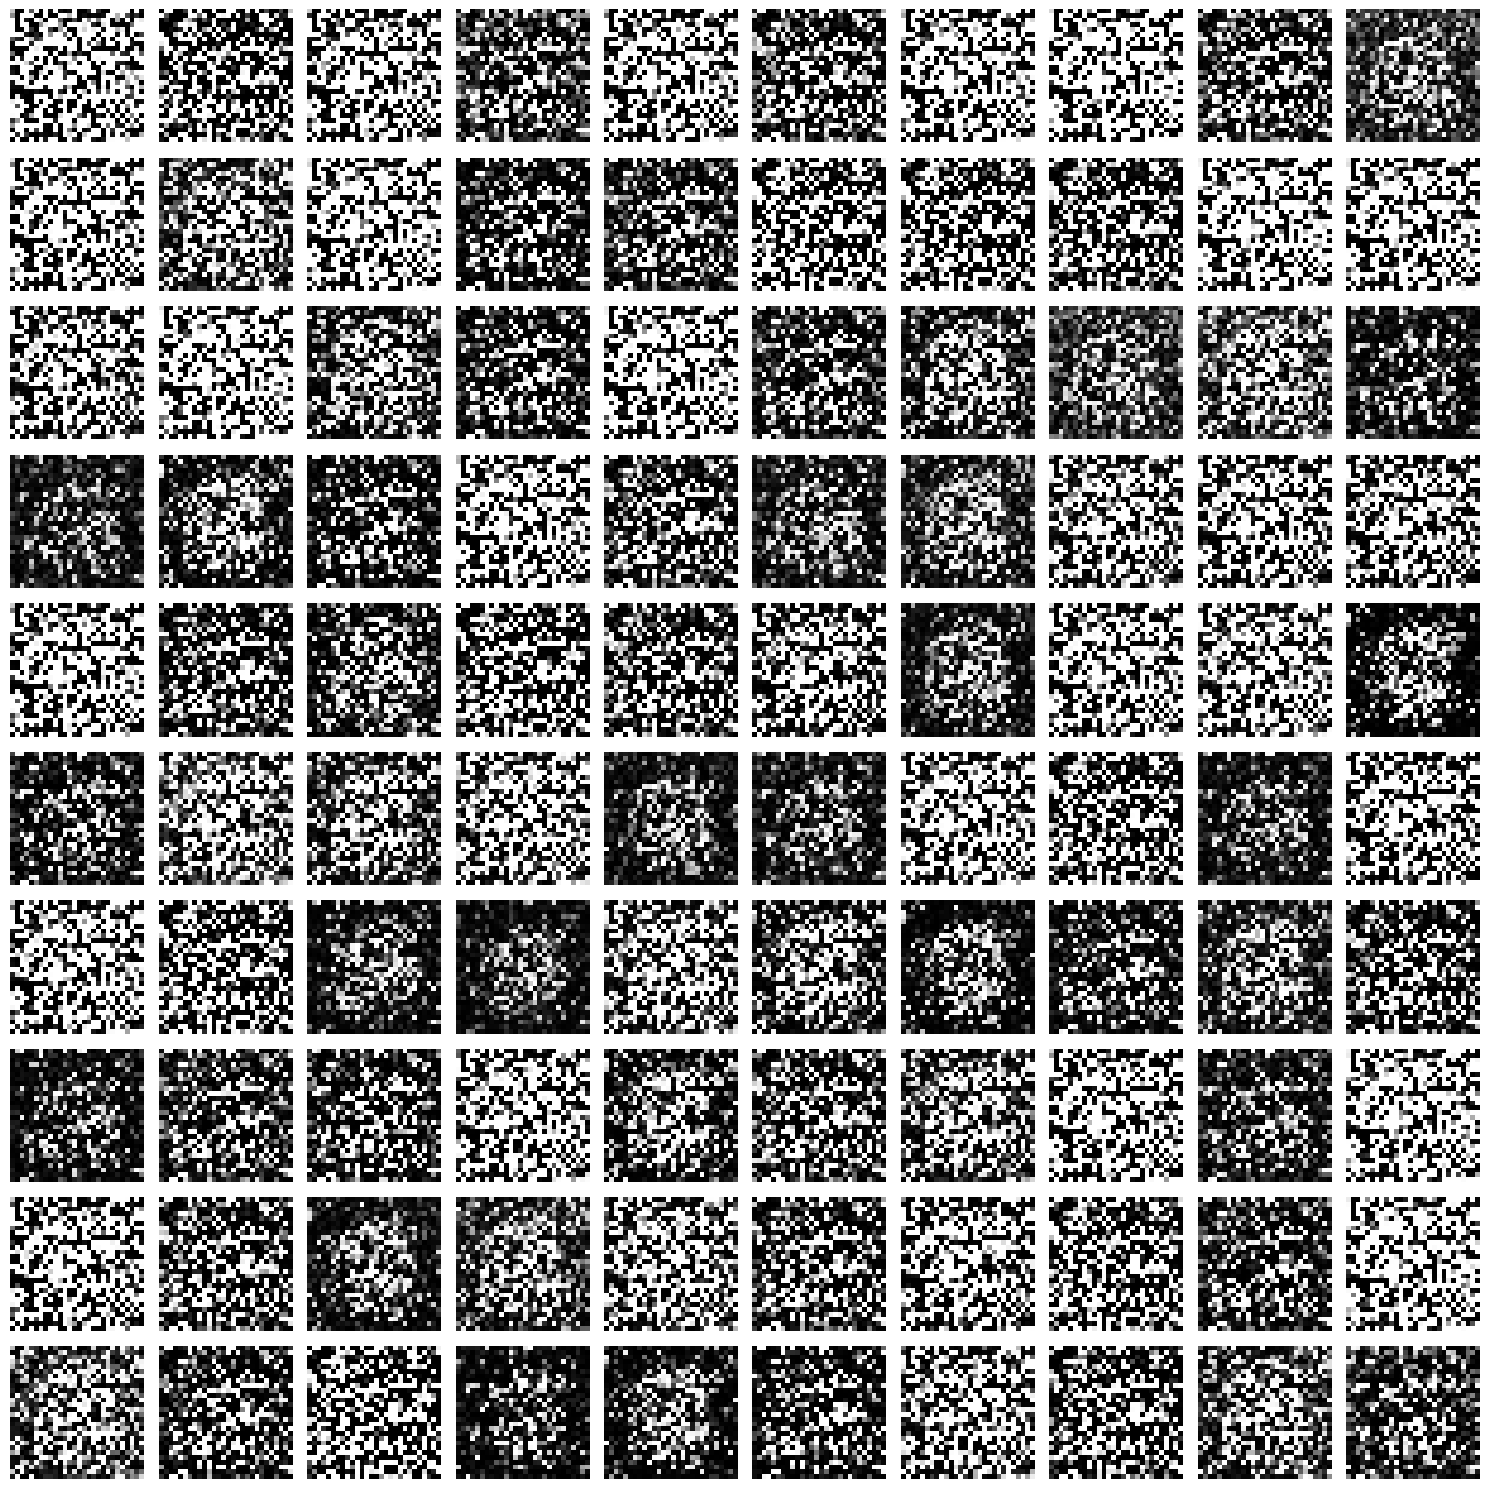

In [14]:
train(X_train,epochs=5,batch_size=128)


In [ ]:
# Funcion de entrenamiento para graficar la loss:
import matplotlib.pyplot as plt

def train(X_train, epochs=5, batch_size=128):
    generator = build_generator()
    discriminator = build_discriminator()
    gan = gan_net(generator, discriminator)

    d_losses = []  # Guardar pérdidas del discriminador
    g_losses = []  # Guardar pérdidas del generador

    for epoch in range(1, epochs + 1):
        print(f"###### Epoch {epoch} ######")
        for _ in range(batch_size):
            noise = np.random.normal(0, 1, [batch_size, 100])
            generated_images = generator.predict(noise)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
            X = np.concatenate([image_batch, generated_images])

            # Etiquetas: 1 para reales, 0 para falsas
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 1

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            d_losses.append(d_loss)  # Guardar pérdida del discriminador

            # Entrenar generador (intenta engañar al discriminador)
            noise = np.random.normal(0, 1, [batch_size, 100])
            y_gen = np.ones(batch_size)  # Generador quiere que todo sea clasificado como real
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)
            g_losses.append(g_loss)  # Guardar pérdida del generador

        # Graficar pérdidas cada 5 épocas
        if epoch % 5 == 0:
            plt.plot(d_losses, label="Discriminator Loss")
            plt.plot(g_losses, label="Generator Loss")
            plt.legend()
            plt.show()


In [ ]:
# Lo mismo para la accuracy
def evaluate_discriminator(discriminator, X_real, X_fake):
    y_real = np.ones((X_real.shape[0], 1))  # Etiquetas reales
    y_fake = np.zeros((X_fake.shape[0], 1))  # Etiquetas falsas

    acc_real = np.mean(discriminator.predict(X_real) > 0.5)  # Precisión en imágenes reales
    acc_fake = np.mean(discriminator.predict(X_fake) < 0.5)  # Precisión en imágenes falsas

    print(f"Precisión en imágenes reales: {acc_real * 100:.2f}%")
    print(f"Precisión en imágenes falsas: {acc_fake * 100:.2f}%")

    return acc_real, acc_fake

# Generar imágenes falsas para evaluar
noise = np.random.normal(0, 1, (100, 100))
generated_images = generator.predict(noise)

# Tomar imágenes reales del dataset
real_images = X_train[np.random.randint(0, X_train.shape[0], 100)]

# Evaluar el discriminador
evaluate_discriminator(discriminator, real_images, generated_images)


In [18]:
# Guardar el modelo

gan.save("gan_model.h5")


NameError: name 'gan' is not defined